## Import Modules

In [1]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.layers import Bidirectional, Concatenate, Dot, Input, LSTM
from keras.layers import RepeatVector, Dense, Activation
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
from keras.optimizers import Adam
from IPython.display import SVG

Using TensorFlow backend.


## Load & Preprocess the data

1. load_data: Loads data from file
2. create_index_mapping: Creates the index - character mapping for human, machine readable dates vocabulary.
3. string_to_int: Creates integer vectors from the character array (string).
4. preprocess_data: Converts the integer vectors to the one-hot encoded vectors and returns these vectors along with vocabularies. (human_vocab, machine_vocab, inv_machine)

In [2]:
class DataPreprocess:
    
    def __init__(self, max_input_length, output_length):
        self.max_input_length = max_input_length
        self.output_length = output_length
    
    def load_data(self, path):
        self.data = pd.read_csv(path)
    
    def create_index_mapping(self):
        human = set()
        machine = set()
        self.dataset = []
        for t in self.data.itertuples():
            h, m = t.human, t.machine
            self.dataset.append((h, m))
            human.update(h)
            machine.update(m)
        self.human_vocab = dict(zip(sorted(human) + ['<unk>', '<pad>'], list(range(len(human) + 2))))
        self.inv_machine = dict(enumerate(sorted(machine)))
        self.machine_vocab = {v:k for k,v in self.inv_machine.items()}
        
    def string_to_int(self, string, length, vocab):
        string = string.lower()
        string = string.replace(',','')
        if len(string) > length:
            string = string[:length]    
        int_vector = list(map(lambda x: vocab[x], string))

        if len(string) < length :
            int_vector += [vocab['<pad>']] * (length - len(string))
        return int_vector
    
    def preprocess_data(self):
        X, Y = zip(*self.dataset)
        X = np.array([self.string_to_int(i, self.max_input_length, self.human_vocab) for i in X])
        Y = np.array([self.string_to_int(t, self.output_length, self.machine_vocab) for t in Y])
        X_oh = to_categorical(X, num_classes=len(self.human_vocab))
        Y_oh = to_categorical(Y, num_classes=len(self.machine_vocab))
        return X_oh, Y_oh, self.human_vocab, self.machine_vocab,self.inv_machine   # (20000, 30, 37), (20000, 10, 11)


## Read data

1. max_input_length: Define maximum length of the human readable date.
2. output_length: YYYY-MM-DD is 10 characters long

In [3]:
max_input_length=30
output_length = 10
data_obj = DataPreprocess(max_input_length=max_input_length, output_length = output_length)
data_obj.load_data('train_dates.csv')
data_obj.create_index_mapping()
X_train, Y_train, human_vocab, machine_vocab, inv_machine = data_obj.preprocess_data()

## Create encoder-decoder model with attention mechanism

1. init: Constructor used for initialization
   * Variables: 
       * max_input_length: Maximum length of input
       * output_length: Length of output.
       * en_lstm_units: Number of Encoder Bidirectional LSTM units. 
       * de_lstm_units: Number of Decoder LSTM units.
   * Layers to calculate context vector: We are initializing the layers and assigning it to variable because while iterating to generate output, it is important to have the same weights.(It should not re-initiaiize the weights every time after each output character).
       * repeat_layer: It will replicate the decoder's previous state to the number of encoder's output.
       * concat_layer: It will concatenate the encoder's output and decoder's preivous state.
       * attention_dense, attention_weights: To calculate the attention weights passing the concatenated result through the small fully-connected network using softmax layer in output.
       * context_vector: Contect vector which is the weighted sum (dot product) of encoder's output and the calculated attention weights.
   * Decoder Layer's
       * decoder_lstm_layer, output_layer: initialize Decoder's lstm and output layer.
2. create_context_vector: This method will create the context vector for single output character.
3. create_model: This method will create the whole network architecture.
    * First Encoder activations are calculated using Bidirectional LSTM.
    * Now for each character to predict:
      * Create the context vectors.
      * Input the context vector along with previous activation and cell_state to the Decoder LSTM layer.
      * Output the character using dense layer and append it to the outputs list.
      * So output will be the predicted list of characters for corresponding input string.

In [4]:
class NetworkArchitecture:
    
    def __init__(self, max_input_length, output_length, en_lstm_units, de_lstm_units):
        # Initialze variables
        self.max_input_length = max_input_length
        self.output_length = output_length
        self.en_lstm_units = en_lstm_units
        self.de_lstm_units = de_lstm_units
        # Initialize layers to calculate context vector
        self.repeat_layer = RepeatVector(self.max_input_length, name = 'repeat_layer')
        self.concat_layer = Concatenate(axis=-1, name = 'concatenate_layer')
        self.attention_dense = Dense(1, activation = "relu", name = 'attention_dense')
        self.attention_weights = Activation('softmax', name='attention_weights'
        self.context_vector = Dot(axes = 1, name = 'context_vector')
        # Initialize layers for decoder network
        self.decoder_lstm_layer = LSTM(self.de_lstm_units, return_state = True, name = 'decoder_lstm')
        self.output_layer = Dense(len(machine_vocab), activation='softmax', name = 'decoder_output')
        
    def create_context_vector(self, encoder_activation, decoder_prev_state):
        decoder_prev_state = self.repeat_layer(decoder_prev_state)
        concat = self.concat_layer([encoder_activation, decoder_prev_state])
        att_dense = self.attention_dense(concat)
        attention_weights = self.attention_weights(att_dense)
        context = self.context_vector([attention_weights, encoder_activation])
        return context
    
    def create_model(self):
        encoder_input = Input(shape=(self.max_input_length, len(human_vocab)))
        de_initial_hidden_state = Input(shape=(self.de_lstm_units,), name='initial_hidden_state')
        de_initial_cell_state = Input(shape=(self.de_lstm_units,), name='initial_cell_state')
        hidden_state = de_initial_hidden_state 
        cell_state = de_initial_cell_state
        outputs = []

        encoder_activations = Bidirectional(LSTM(self.en_lstm_units, return_sequences=True, name = 'encoder_bi-lstm'))(encoder_input)
        for t in range(self.output_length):
            context = self.create_context_vector(encoder_activations, cell_state)
            hidden_state, _, cell_state = self.decoder_lstm_layer(context, initial_state = [hidden_state, cell_state])
            out = self.output_layer(cell_state)
            outputs.append(out)

        model = Model(inputs = [encoder_input, de_initial_hidden_state, de_initial_cell_state], outputs = outputs)    
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

## Initialze variables

In [5]:
en_lstm_units = 64
de_lstm_units = 128
decoder_state = np.zeros((X_train.shape[0], de_lstm_units))
decoder_cell_state = np.zeros((X_train.shape[0], de_lstm_units))
outputs = list(Y_train.swapaxes(0,1))  # (10, 20000, 11) output should be of shape (1, machine_vocab)

## Create the model architecture

In [6]:
network_obj = NetworkArchitecture(max_input_length = 30, output_length = 10, en_lstm_units = 64, de_lstm_units = 128)
model = network_obj.create_model()

## Summary of the Network Model

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
initial_cell_state (InputLayer) (None, 128)          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 128)      52224       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_layer (RepeatVector)     (None, 30, 128)      0           initial_cell_state[0][0]         
                                                                 decoder_lstm[0][2]               
          

## Graph of Network Model

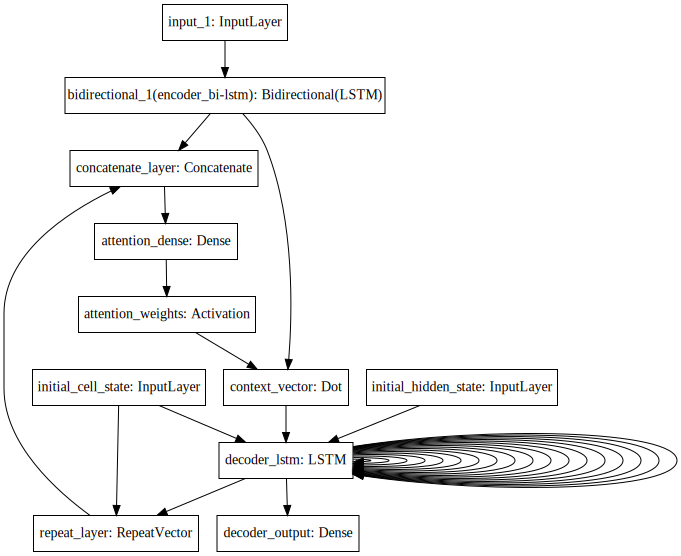

In [8]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train the model

In [9]:
model.fit([X_train, decoder_state, decoder_cell_state], outputs, epochs=10, batch_size=64)

Epoch 1/10
19900/19900 [==============================] - 83s 4ms/step - loss: 10.3348 - decoder_output_loss: 1.7521 - decoder_output_acc: 0.7791 - decoder_output_acc_1: 0.9012 - decoder_output_acc_2: 0.6531 - decoder_output_acc_3: 0.3020 - decoder_output_acc_4: 0.8738 - decoder_output_acc_5: 0.6595 - decoder_output_acc_6: 0.3542 - decoder_output_acc_7: 0.8201 - decoder_output_acc_8: 0.5575 - decoder_output_acc_9: 0.3560
Epoch 2/10
19900/19900 [==============================] - 63s 3ms/step - loss: 2.9739 - decoder_output_loss: 0.7291 - decoder_output_acc: 0.9729 - decoder_output_acc_1: 0.9742 - decoder_output_acc_2: 0.8471 - decoder_output_acc_3: 0.6982 - decoder_output_acc_4: 0.9997 - decoder_output_acc_5: 0.9710 - decoder_output_acc_6: 0.8546 - decoder_output_acc_7: 0.9996 - decoder_output_acc_8: 0.8815 - decoder_output_acc_9: 0.7251
Epoch 3/10
19900/19900 [==============================] - 64s 3ms/step - loss: 1.3036 - decoder_output_loss: 0.2848 - decoder_output_acc: 0.9808 - deco

## Read the test data

In [10]:
data = pd.read_csv('test_dates.csv')

## Preprocess the test data (human readable dates to one-hot encoded vectors)

In [11]:
X_test = []
Y_test = []
for t in data.itertuples():
    h, m = t.human, t.machine
    X_test.append(h)
    Y_test.append(m)

## Predict the values from the model

In [14]:
for example in X_test:
    int_vector = data_obj.string_to_int(example, max_input_length, human_vocab)
    int_vector = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), int_vector))).swapaxes(0,1)
    prediction = model.predict([np.expand_dims(int_vector.T, axis = 0), decoder_state, decoder_cell_state])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output))

source: saturday april 11 2015
output: 2015-04-11
source: 8 may 1990
output: 1990-05-08
source: 9 aug 2017
output: 2017-08-09
source: sunday november 19 1989
output: 1989-11-19
source: 15 mar 1985
output: 1985-03-15
source: saturday july 27 1991
output: 1991-07-27
source: june 2 1972
output: 1972-06-02
source: thursday july 17 1975
output: 1975-07-17
source: may 11 2006
output: 2006-05-11
source: 5 dec 2007
output: 2007-12-05
source: tuesday september 27 2011
output: 2011-09-27
source: may 20 1973
output: 1973-05-20
source: may 1 1997
output: 1997-05-01
source: sunday september 6 2009
output: 2009-09-06
source: monday july 16 1990
output: 1990-07-16
source: 3 june 2015
output: 2015-06-03
source: december 17 2003
output: 2003-12-17
source: wednesday january 27 1999
output: 1999-01-27
source: tuesday december 24 1974
output: 1974-12-24
source: may 16 1991
output: 1991-05-16
source: august 7 2015
output: 2015-08-07
source: thursday september 6 1973
output: 1973-09-06
source: sunday august